In [1]:
# %matplotlib inline
import pandas as pd
import pingouin as pg
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import warnings
import decimal 
from numpy.polynomial.polynomial import polyfit
from colorama import Fore
from sklearn import linear_model
from statsmodels.graphics.gofplots import qqplot_2samples

df_league_all = pd.read_csv(r'league_all.csv', index_col=0)
df_league_slider = pd.read_csv(r'league_slider.csv', index_col=0)
df_league_4seam = pd.read_csv(r'league_4seam.csv', index_col=0)

df_team_all = pd.read_csv(r'team_all.csv', index_col=0)
df_team_slider = pd.read_csv(r'team_slider.csv', index_col=0)
df_team_4seam = pd.read_csv(r'team_4seam.csv', index_col=0)

In [2]:
### TEST BOX:

### LEAGUE-WIDE
# df_league_all.info()
# df_league_all.head()
# df_league_slider.info()
# display(df_league_slider)
# df_league_4seam.info()
# df_league_4seam.head()

### TEAM
# df_team_all.info()
# df_team_all.head()
# df_team_slider.info()
# df_team_slider.head()
# df_team_4seam.info()
# df_team_4seam.head()

In [3]:
### COLORS: for league and teams

colors ={
    'League':['#002D72','#D50032'],
    'ARI':['#A71930','#E3D4AD'], 'ATL':['#CE1141','#13274F'], 'BAL':['#FC4C02','#000000'], 'BOS':['#BD3039','#0C2340'],
    'CHC':['#0E3386','#CC3433'], 'CIN':['#C6011F','#000000'], 'CLE':['#0C2340','#E31937'], 'COL':['#33006F','#C4CED4'], 
    'CWS':['#27251F','#C4CED4'], 'DET':['#0C2340','#FA4616'], 'HOU':['#002D62','#EB6E1F'], 'KC':['#004687','#BD9B60'], 
    'LAA':['#003263','#BA0021'], 'LAD':['#005A9C','#EF3E42'], 'MIA':['#000000','#00A3E0'], 'MIL':['#FFC52F','#12284B'], 
    'MIN':['#002B5C','#D31145'], 'NYM':['#002D72','#FF5910'], 'NYY':['#0C2340','#C4CED3'], 'OAK':['#115740','#EFB21E'], 
    'PHI':['#E81828','#002D72'], 'PIT':['#27251F','#FDB827'], 'SD':['#693F23','#FFC425'], 'SEA':['#0C2C56','#005C5C'], 
    'SF':['#FD5A1E','#27251F'], 'STL':['#C41E3A','#0C2340'], 'TB':['#092C5C','#8FBCE6'], 'TEX':['#003278','#C0111F'], 
    'TOR':['#134A8E','#E8291C'], 'WSH':['#AB0003','#14225A']
        }

In [4]:
### ASSUMPTION FUNCTION: checking data for normality/homogeneity of variance
### for LEAGUE-WIDE and TEAM stats

def check_assum(df, stat, team):
## SUBSET TARGET DATA
    if team != 'League':
        df=df[df['team_name']==team]        
    before_query = df.query('period == "before"')[stat]
    transition_query = df.query('period == "transition"')[stat]
    after_query = df.query('period == "after"')[stat]

## CHECK NORMALITY to ensure that future tests, which assume normality, are appropriate to use
    norm_before = pg.normality(before_query)        
    norm_transition = pg.normality(transition_query)
    norm_after = pg.normality(after_query)    
    before = norm_before.normal
    transition = norm_transition.normal
    after = norm_after.normal   
    df_stat = df[['period',stat]]    
    period_normal= [['before', norm_before, before],['transition', norm_transition, transition], ['after', norm_after, after]]
    normal = [norm_before, norm_transition, norm_after]   
    print('\033[1m'+'for '+ team +'\033[0m','\n')
    
    for i in period_normal:
        print('Normality of ' + "'" + i[0].upper() + "' " + stat + ' stats:','\n', i[1], '\n')
        if i[2].bool() == True:
            pass
        else:
## GENERATE histogram and qq-plot to visually analyse if the data is normal
            f = plt.figure(figsize=(13.75,6.25))
            ax1 = f.add_subplot(121)
            ax2 = f.add_subplot(122)
            
            box = ax2.get_position()
            box.x0 = box.x0 + 0.05
            box.x1 = box.x1 + 0.05
            ax2.set_position(box)
## HISTOGRAM        
            df = df_stat[df_stat['period'] == i[0]]
            ax1.grid(color='gray', linestyle='dashed')
            ax1.hist(df[stat], color = colors[team][0]) 
            title = 'Distribution of ' + stat +'\n'+ ' in ' + "'" + i[0].upper() + "'" + ' period'            
            ax1.set_title(title, size = 18, fontstyle = 'normal', weight = 600, y = 1.02)
            ax1.set(xlabel=stat, ylabel='Number of Days')
            for item in ([ax1.xaxis.label, ax1.yaxis.label]):
                item.set_fontsize(14)            
## QQ-PLOT           
            pg.qqplot(df[stat], dist = 'norm',ax=ax2)
            title = "'" + i[0].upper() + "'" + ' ' + stat + ' QQ-PLOT'
            ax2.set_title(title, size = 18, fontstyle = 'normal', weight = 600, y = 1.02)
            for item in ([ax2.xaxis.label, ax2.yaxis.label]):
                item.set_fontsize(14)
                
            plt.show()
            
## CHECK HOMOGENEITY OF VARIANCE (levene): make sure that future tests, which assume equal variances, are appropriate to use
    levene_all=stats.levene(before_query, transition_query, after_query)     
    print("LEVENE TEST FOR DATA THAT MIGHT NOT BE NORMAL:",'\n',"Homogeneity of VARIANCE between all periods:", '\n', levene_all)
    if levene_all.pvalue>.05:
        print(Fore.GREEN + 'ASSUME EQUAL VARIANCES' + Fore.RESET,'\n')
    else:
        print(Fore.RED+"Not good, but it may be the really small 'transition' period that is messing things up"+Fore.RESET,'\n')
        levene_before_and_after=stats.levene(before_query, after_query)
        print("2.LEVENE TEST FOR DATA THAT MIGHT NOT BE NORMAL:",'\n',"Homogeneity of VARIANCE between BEFORE and AFTER periods:",'\n', levene_before_and_after)
        if levene_before_and_after.pvalue>.05:
            print(Fore.GREEN + 'ASSUME EQUAL VARIANCES' + Fore.RESET,'\n')
        else:
            print(Fore.RED+'POTENTIAL ISSUE'+Fore.RESET,'\n')
## CHECK HOMOGENEITY OF VARIANCE (bartlett): similar to levene test. It tests for equal variances, but under the assumption of normality.       
    w, pvalue = stats.bartlett(before_query, transition_query, after_query) 
    print("BARTLETT TEST FOR DATA ASSUMED TO BE NORMAL:",'\n',"Homogeneity of VARIANCE between all periods:", '\n',w, pvalue)
    if pvalue>.05:
        print(Fore.GREEN+'ASSUME EQUAL VARIANCES'+Fore.RESET,2*'\n')
    else:
        print(Fore.RED+"Not good, but this test is more sensitive to non-normal data. Lets just compare BEFORE and AFTER period"+Fore.RESET,'\n')
        w, pvalue = stats.bartlett(before_query, after_query)
        print("2.BARTLETT TEST FOR DATA ASSUMED TO BE NORMAL:",'\n',"Homogeneity of VARIANCE between BEFORE and AFTER periods:",'\n',w, pvalue)
        if pvalue>.05:
            print(Fore.GREEN+'ASSUME EQUAL VARIANCES'+Fore.RESET,2*'\n')
        else:
            print(Fore.RED+'POTENTIAL ISSUE'+Fore.RESET,2*'\n')

for League 

Normality of 'BEFORE' spin_rate stats: 
                   W      pval  normal
spin_rate  0.973666  0.187234    True 

Normality of 'TRANSITION' spin_rate stats: 
                   W      pval  normal
spin_rate  0.974768  0.895187    True 

Normality of 'AFTER' spin_rate stats: 
                  W     pval  normal
spin_rate  0.96586  0.01021   False 



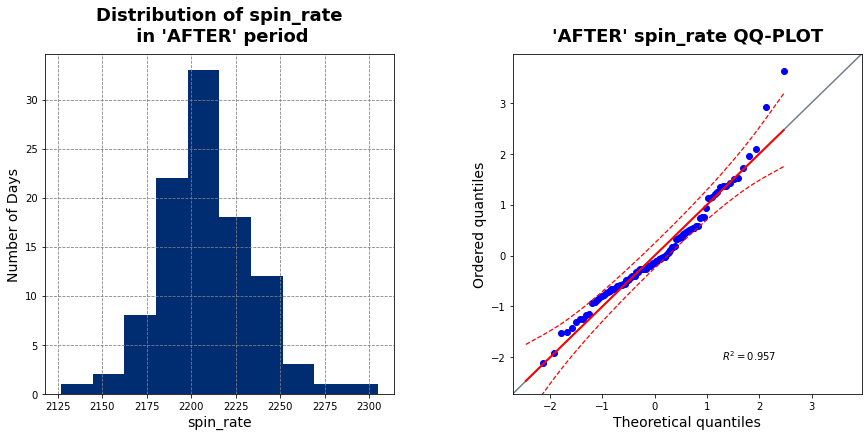

LEVENE TEST FOR DATA THAT MIGHT NOT BE NORMAL: 
 Homogeneity of VARIANCE between all periods: 
 LeveneResult(statistic=2.728037290725679, pvalue=0.06806536214103302)
ASSUME EQUAL VARIANCES 

BARTLETT TEST FOR DATA ASSUMED TO BE NORMAL: 
 Homogeneity of VARIANCE between all periods: 
 6.9898598461351575 0.03035087525833515
Not good, but this test is more sensitive to non-normal data. Lets just compare BEFORE and AFTER period 

2.BARTLETT TEST FOR DATA ASSUMED TO BE NORMAL: 
 Homogeneity of VARIANCE between BEFORE and AFTER periods: 
 0.24968512782473914 0.6172968759181048
ASSUME EQUAL VARIANCES 




In [5]:
### TEST BOX: run functions with different stat arguments (ex:'spin_rate','WHIFF'), and for different teams

assum_stat='spin_rate'
assum_team='OAK' 

### checking LEAGUE-WIDE assumptions
check_assum(df_league_all,assum_stat,'League')
# check_assum(df_league_slider,assum_stat,'League')
# check_assum(df_league_4seam,assum_stat,'League')

### checking TEAM assumptions
# check_assum(df_team_all,assum_stat,assum_team)
# check_assum(df_team_slider,assum_stat,assum_team)
# check_assum(df_team_4seam,assum_stat,assum_team)

In [6]:
### T-TEST FUNCTION: Compare BEFORE and AFTER periods for LEAGUE-WIDE and TEAM stats

def t_test(df, stat, team, title=''):
## SUBSET TARGET DATA   
    if team != 'League':
        df=df[df['team_name']==team]
        
    before_query = df.query('period == "before"')[stat]
    after_query = df.query('period == "after"')[stat]
    
## T-TEST
    test_results = pg.ttest(before_query, after_query)
    display(test_results)
    if test_results['p-val'].item()<.05:
        print(Fore.RED+'THERE IS A SIGNIFICANT DIFFERENCE IN MEAN '+stat)
        if test_results['cohen-d'].item()>=.8:
            print('\033[1m'+'LARGE EFFECT'+'\033[0m'+Fore.RESET)
        elif test_results['cohen-d'].item()>=.5:
            print('MEDIUM EFFECT'+Fore.RESET)
        else:
            print('LITTLE TO NO EFFECT'+Fore.RESET)
    else:
        print(Fore.GREEN+'NO SIGNIFICANT DIFFERENCE IN MEAN '+stat+Fore.RESET)
## GRAPH
    df_sub=df[['period',stat]]
    df_before_and_after=df_sub[(df_sub['period']=='before') | (df_sub['period']=='after')]
    medianprops = medianprops=dict(color="#00FFFF", alpha=0.7)                                # other options: #75B7FD,
    figure = plt.figure(figsize=[5,7.5])     #    [3.33,5]
    axis = figure.add_subplot(111)
    bxplt = sns.boxplot(x='period', y=stat, data=df_before_and_after, color=colors[team][0],medianprops=medianprops,ax=axis)        
    bxplt = sns.swarmplot(x='period', y=stat, data=df_before_and_after, color=colors[team][1],size=5.5)
    plt.suptitle(title+" 'BEFORE' & 'AFTER' "+stat, size = 20, fontstyle = 'normal', weight = 600, y = 1.00)
    plt.title('for '+ team, size = 17, fontstyle = 'italic', color=colors[team][1], weight = 600, y=1.03)
    plt.xlabel('period', size=17, fontstyle='normal', weight = 600)
    plt.ylabel(stat, size=17, fontstyle = 'normal', weight = 600)
    plt.show()
    print('\n'*2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.31306,101.873788,two-sided,1.046321e-19,"[204.29, 291.15]",2.000008,2.456e+18,1.0


THERE IS A SIGNIFICANT DIFFERENCE IN MEAN spin_rate
LARGE EFFECT


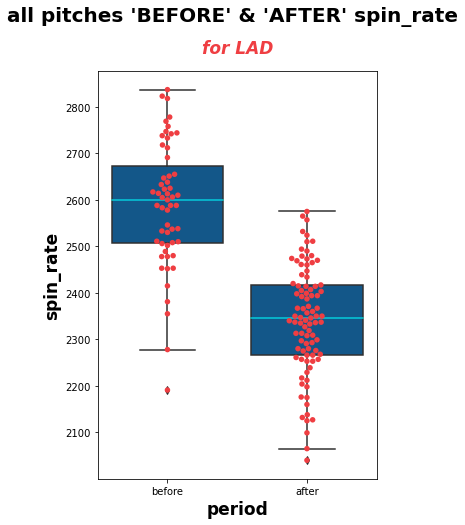

In [8]:
### TEST BOX: test LEAGUE-WIDE and TEAM stats
t_stat='spin_rate'
t_team='LAD'

t_title_all='all pitches'
t_title_slider="slider"
t_title_4seam='4-seam fastball'

### LEAGUE-WIDE t-test
# t_test(df_league_all, t_stat, 'League', t_title_all)
# t_test(df_league_slider, t_stat, 'League', t_title_slider)
# t_test(df_league_4seam, t_stat, 'League', t_title_4seam)

### TEAM t-test
t_test(df_team_all, t_stat, t_team, t_title_all)
# t_test(df_team_slider, t_stat, t_team, t_title_slider)
# t_test(df_team_4seam, t_stat, t_team, t_title_4seam)

In [9]:
### ANOVA FUNCTION: Compare BEFORE, TRANSITION, AFTER periods for LEAGUE-WIDE and TEAM stats

def anova(df, stat, team, title=''):
    if team != 'League':
        df=df[df['team_name']==team] 
        
    aov=pg.anova(data=df,dv=stat,between='period',detailed=True) 
    display(aov)    
    lis=[]
    for i in aov['p-unc']:                      # converts the p-value from scientific notation (Ex: 1.99e-32) to a float that can be analyzed
        lis.append(i)  
    cleanedList = [x for x in lis if x == x]    # since nan != nan in this situation, this gets rid of nan.          
    
    for i in cleanedList:
        y= float(i)
        if float('%.040f' % y) <.05:
            print(Fore.RED+'THERE IS A SIGNIFICANT DIFFERENCE IN MEAN '+stat+' OVER THREE PERIODS'+Fore.RESET)
## POSTHOC EFFECT SIZE ANALYSIS 
            posthoc=pg.pairwise_tukey(data=df, dv=stat, between='period', effsize='hedges').round(3)  
            display(posthoc)
        else:
            print(Fore.GREEN+'NO SIGNIFICANT DIFFERENCE IN MEAN '+stat+' OVER THREE PERIODS'+Fore.RESET,'\n')
## GRAPH
    medianprops= medianprops=dict(color="#00FFFF", alpha=0.7) 
    figure = plt.figure(figsize=[7.5,7.5])
    axis = figure.add_subplot(111)
    bxplt = sns.boxplot(x='period', y=stat, data=df, color=colors[team][0], medianprops=medianprops,ax=axis)
    bxplt = sns.swarmplot(x="period", y=stat, data=df, color=colors[team][1],size=5.5)  
    plt.suptitle(title+' '+stat+' OVER THREE PERIODS', size = 20, fontstyle = 'normal', weight = 600, y = 1.00)
    plt.title('for '+ team, size = 17, fontstyle = 'italic', color=colors[team][1], weight = 600, y=1.03)
    plt.xlabel('period', size=17, fontstyle='normal', weight = 600)
    plt.ylabel(stat, size=17, fontstyle = 'normal', weight = 600)
    plt.show()
    print('\n'*2)

,Source,SS,DF,MS,F,p-unc,np2
0,period,178936.054777,2,89468.027388,107.672276,1.992774e-31,0.546082
1,Within,148736.308511,179,830.929098,NaN,NaN,NaN


THERE IS A SIGNIFICANT DIFFERENCE IN MEAN spin_rate OVER THREE PERIODS


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,after,before,2208.851,2276.432,-67.582,4.605,-14.674,0.000,-2.334
1,after,transition,2208.851,2234.308,-25.457,7.557,-3.369,0.003,-0.877
2,before,transition,2276.432,2234.308,42.125,7.865,5.356,0.000,1.447


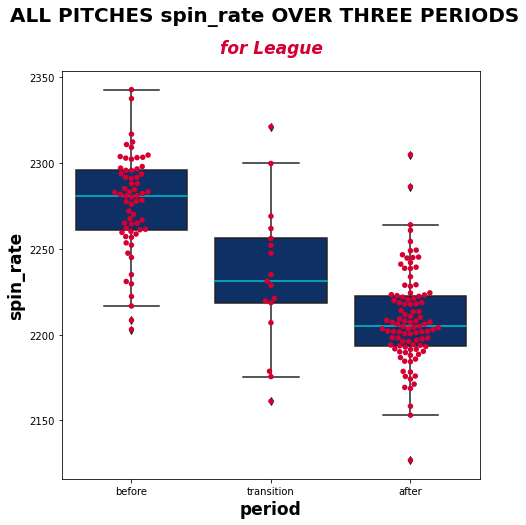

In [11]:
### TEST BOX: test LEAGUE-WIDE and TEAM stats
a_stat = 'spin_rate'
a_team = 'NYM'

a_title_all='ALL PITCHES'
a_title_slider='SLIDER'
a_title_4seam='4-SEAM FASTBALL'

### LEAGUE-WIDE anova
anova(df_league_all, a_stat, 'League', a_title_all)
# anova(df_league_slider, a_stat, 'League', a_title_slider)
# anova(df_league_4seam,a_stat, 'League', a_title_4seam)

### TEAM anova
# anova(df_team_all, a_stat, a_team, a_title_all)
# anova(df_team_slider, a_stat, a_team, a_title_slider)
# anova(df_team_4seam, a_stat, a_team, a_title_4seam)

In [12]:
### HEAT MAP FUNCTION: compare impact of pairs of stats on one value. For LEAGUE-WIDE and TEAMs
def heat(df, value, x, y, title, team):
    if team != 'League':
        df=df[df['team_name']==team]
    row_bin=pd.cut(df[x],bins=10,precision=1)
    col_bin=pd.cut(df[y],bins=10, precision=1)
    df_pivot=pd.pivot_table(df,values=value,
                           index=[row_bin],
                           columns=col_bin)
    figure = plt.figure(figsize=[7.5,6.0], edgecolor='k')
    axis = figure.add_subplot(111)
    
    df_heatmap=sns.heatmap(df_pivot,
                           cmap='gist_heat_r',     # other options: 'rocket_r', 'Reds', 'hot_r', 'inferno_r'
                           annot=True,
                           linewidths=.01, 
                           linecolor='black',
                           ax=axis)
    
    for _, spine in df_heatmap.spines.items():
        spine.set_visible(True)
    plt.suptitle(title+' '+value+' heatmap', size = 20, fontstyle = 'normal', weight = 600, y = 1.0, x = .45)
    plt.title('for '+team, size = 17, fontstyle = 'italic', color=colors[team][1], weight = 600, y=1.025) 
    plt.xlabel(x, size=17, fontstyle='normal', weight = 600)
    plt.ylabel(y, size=17, fontstyle = 'normal', weight = 600)
    plt.show()
    print('\n')

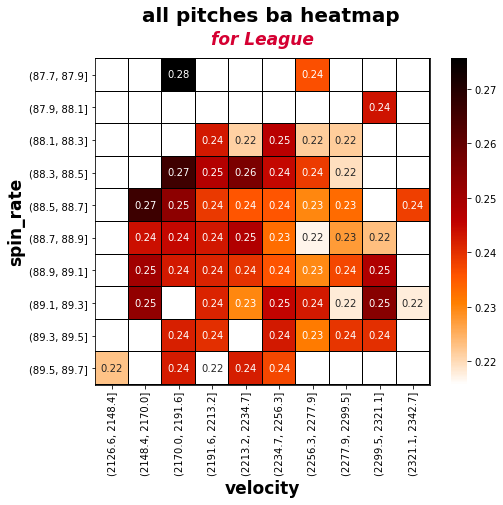

In [13]:
#### TEST BOX: beware of y and x values. For example: It wouldn't make sense to use sv_ratio & spin_rate to see what velocity is since sv_ratio is spin_rate/velocity.
h_stat='ba'                                      #It wouldnt make sense to use WHIFF and Swstr to look at swings since WHIFF and swstr are stats based on swings
h_team= 'ATL'
x='velocity'
y='spin_rate'

h_title_all='all pitches'
h_title_slider='slider'
h_title_4seam='4-seam fastball'

### LEAGUE-WIDE heatmap
heat(df_league_all, h_stat, x, y, h_title_all, 'League')
# heat(df_league_slider, h_stat, x, y, h_title_slider, 'League')
# heat(df_league_4seam, h_stat, x, y, h_title_4seam, 'League')

### TEAM heatmap
# heat(df_team_all, h_stat, x, y, h_title_all, h_team)
# heat(df_team_slider, h_stat, x, y, h_title_slider, h_team)
# heat(df_team_4seam, h_stat, x, y, h_title_4seam, h_team)

In [14]:
### LINE-CHART FUNCTION

def line_chart(df, stat, title, team):
    if team != 'League':
        df=df[df['team_name']==team]
    df_line=df.reset_index()
    df_line['game_date'] = pd.to_datetime(df_line['game_date'], errors='coerce') #allows me to use game_date as axis/label. 
    month=['2021-04-01','2021-05-01','2021-06-04','2021-06-20','2021-08-01','2021-09-01','2021-10-01']
    
    df_line[ '7day_rolling_avg' ] = df_line[stat].rolling( 7).mean()
## GRAPH
    figure = plt.figure(figsize=[9,6])
    axis = figure.add_subplot(111)
    plot = df_line.plot(x='game_date',
                        y=[stat,'7day_rolling_avg'],
                        kind='line',
                        grid=True,
                        color=[colors[team][0],colors[team][1]],
                        rot=45,
                        label=[stat,'7day_rolling_avg'],
                        ax=axis)
    
    transition_period = plot.get_xgridlines()
    pre_line = transition_period[2]
    pre_line.set_color('blue')
    pre_line.set_alpha(.5)
    pre_line.set_linestyle('--')
    pre_line.set_linewidth(2)    
    start_line = transition_period[3]
    start_line.set_color('red')
    start_line.set_alpha(.5)
    start_line.set_linewidth(2)
    
    plt.legend(loc = 'best')
    phrase=' over 2021 season'    
    plt.suptitle(title+' '+stat+' '+phrase, size = 20, fontstyle = 'normal', weight = 600, y = 1.02) #, x = .45)
    plt.title('for '+team, size = 17, fontstyle = 'italic', color=colors[team][1], weight = 600, y=1.03) 
    plt.xlabel('game_date', size=17, fontstyle='normal', weight = 600)
    plt.ylabel(stat, size=17, fontstyle = 'normal', weight = 600)
    plt.xticks(month)
    plt.ylabel(stat)

    plt.show()

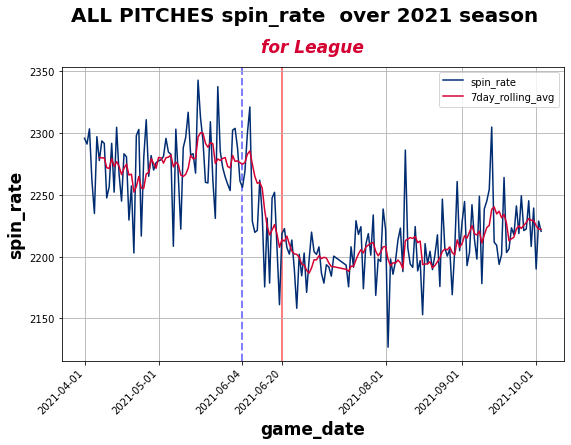

In [15]:
### TEST BOX: see LEAGUE-WIDE and TEAM stats over time
l_stat='spin_rate'
l_team= 'PIT'

l_title_all='ALL PITCHES'
l_title_slider='SLIDER'
l_title_4seam='4-SEAM FASTBALL'

### LEAGUE-WIDE line chart
line_chart(df_league_all, l_stat, l_title_all, 'League')
# line_chart(df_league_slider, l_stat, l_title_slider, 'League')
# line_chart(df_league_4seam, l_stat, l_title_4seam, 'League')

### TEAM line chart
# line_chart(df_team_all, l_stat, l_title_all, l_team)
# line_chart(df_team_slider, l_stat, l_title_slider, l_team)
# line_chart(df_team_4seam, l_stat, l_title_4seam, l_team)

In [15]:
### SUB PERIOD FUNCTION: create dataframe for specific period. 'AFTER' period is more indicative of what future performance will be

def sub_period(df,time):
    dfnew=df[df['period']==time]
    return dfnew

## periods
b4='before'
tr='transition'
aft='after'

## LEAGUE and TEAM dataframes
LA=df_league_all
LS=df_league_slider
L4=df_league_4seam

TA=df_team_all
TS=df_team_slider
T4=df_team_4seam

## quick way to create. Just change arguments
df_before=sub_period(TA,b4)
df_tran=sub_period(TA,tr)
df_after=sub_period(TA,aft)

In [20]:
### CORRELATION function(s)

## 1. Gives more information, but not as clean
def correlation_1(df,team,title):
    cor_stats=['ba','spin_rate','velocity','sv_ratio','WHIFF','swstr','hits','woba','slg','iso','babip','whiffs','swings','takes']
    if team != 'League':
        df=df[df['team_name']==team]
    print('\033[1m'+team+' PAIRWISE CORRELATION'+'\033[0m'+Fore.RESET,'\n','for '+title)
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    graph = pg.pairwise_corr(df, columns=cor_stats, method='pearson')   
    display(pg.pairwise_corr(df, columns=cor_stats, method='pearson'))


## 2. Clean correlation-matrix w/ heatmap
def correlation_2(df,team,title):
    cor_stats=['ba','spin_rate','velocity','sv_ratio','WHIFF','swstr','hits','woba','slg','iso','babip','whiffs','swings','takes']
    print('\033[1m'+team+' CORRELATION-MATRIX'+'\033[0m'+Fore.RESET,'\n','for '+title)
    
    if team != 'League':
        df=df[df['team_name']==team]
        
    df_corre2=df[cor_stats]
    corre=df_corre2.corr()
    display(corre)
    figure = plt.figure(figsize=[11.5,7.667])
    axis = figure.add_subplot(111)
    mask = np.triu(np.ones_like(corre, dtype=bool))
    h_map = sns.heatmap(corre, mask=mask, cmap='bwr', annot=True, ax = axis)

League CORRELATION-MATRIX 
 for all_pitches


,ba,spin_rate,velocity,sv_ratio,WHIFF,swstr,hits,woba,slg,iso,babip,whiffs,swings,takes
ba,1.000000,-0.256629,0.026882,-0.257056,-0.511151,-0.444237,0.948380,0.901342,0.823368,0.514222,0.862495,-0.209298,0.442450,0.229858
spin_rate,-0.256629,1.000000,-0.022370,0.976391,0.394126,0.305353,-0.234907,-0.273084,-0.261157,-0.207134,-0.080256,0.288975,-0.164809,0.094174
velocity,0.026882,-0.022370,1.000000,-0.237224,0.045951,0.113008,0.027369,-0.020028,-0.053113,-0.100184,0.098306,0.153836,0.192151,-0.011953
sv_ratio,-0.257056,0.976391,-0.237224,1.000000,0.372917,0.273191,-0.235529,-0.263888,-0.244240,-0.181200,-0.100899,0.247730,-0.200685,0.092043
WHIFF,-0.511151,0.394126,0.045951,0.372917,1.000000,0.925314,-0.476829,-0.481175,-0.430454,-0.277550,-0.274481,0.788951,-0.243184,-0.113238
swstr,-0.444237,0.305353,0.113008,0.273191,0.925314,1.000000,-0.397844,-0.483589,-0.384133,-0.256594,-0.226152,0.813540,-0.095072,-0.355461
hits,0.948380,-0.234907,0.027369,-0.235529,-0.476829,-0.397844,1.000000,0.841975,0.781946,0.489415,0.818494,-0.076916,0.614691,0.327831
woba,0.901342,-0.273084,-0.020028,-0.263888,-0.481175,-0.483589,0.841975,1.000000,0.928008,0.744420,0.659381,-0.229756,0.363213,0.336283
slg,0.823368,-0.261157,-0.053113,-0.244240,-0.430454,-0.384133,0.781946,0.928008,1.000000,0.910115,0.515921,-0.227598,0.296235,0.146720
iso,0.514222,-0.207134,-0.100184,-0.181200,-0.277550,-0.256594,0.489415,0.744420,0.910115,1.000000,0.149952,-0.191312,0.124777,0.054439


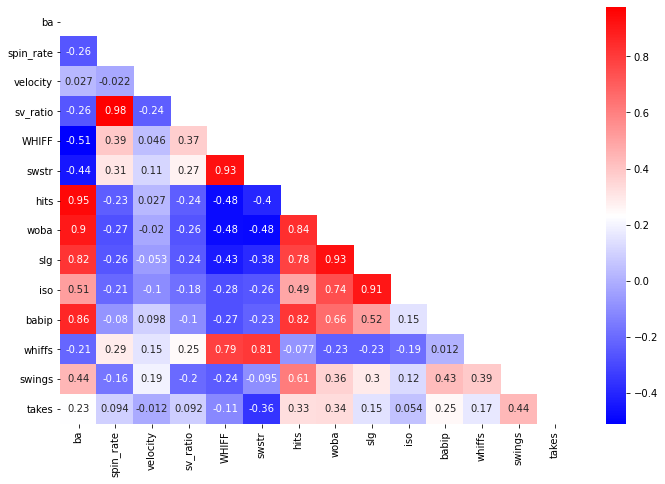

In [21]:
### TEST BOX: for LEAGUE and TEAM stats
cor_team = 'BOS'
cor_title_all = 'all_pitches'
cor_title_slider = 'slider'
cor_title_4seam = '4-seam fastball'

## correlation_1: for more information
## LEAGUE
# correlation_1(df_league_all,'League', cor_title_all)
# correlation_1(df_league_slider,'League',cor_title_slider)
# correlation_1(df_league_4seam,'League',cor_title_4seam)
## TEAM
# correlation_1(df_team_all, cor_team, cor_title_all)
# correlation_1(df_team_slider, cor_team, cor_title_slider)
# correlation_1(df_team_4seam, cor_team, cor_title_4seam)

# ## correlation_2: for better visual
# ## LEAGUE
correlation_2(df_league_all,'League', cor_title_all)
# correlation_2(df_league_slider,'League', cor_title_slider)
# correlation_2(df_league_4seam,'League', cor_title_4seam)
# ## TEAM
# correlation_2(df_team_all,cor_team, cor_title_all)                                
# correlation_2(df_team_slider,cor_team, cor_title_slider)
# correlation_2(df_team_4seam,cor_team, cor_title_4seam)

In [24]:
### SIMPLE and MULTIPLE REGRESSION FUNCTION

def lin_regression(df, dep_var, ind_var_list, team, title):
    if team != 'League':
        df=df[df['team_name']==team]
############################################################################################################################
        
## SIMPLE LINEAR REGRESSION ############################### 
    if len(ind_var_list) == 1:
## OLS report
        ind = df[ind_var_list[0]]
        y = df[dep_var]
        x = sm.add_constant(ind)             
        result = sm.OLS(y, x).fit()        
        print(result.summary())
## R^2 for graph      
        ols = linear_model.LinearRegression()
        model = ols.fit(x, y)
        r2 = model.score(x, y)       
## GRAPH 
        figure = plt.figure(figsize = [9,6])
        axis = figure.add_subplot(111)        
        b, m = polyfit(ind, df[dep_var], 1)
        plt.scatter(ind, df[dep_var],color = colors[team][0], alpha=0.7, label = 'Sample data')
        plt.plot(ind, b + m * ind, color = colors[team][1], linestyle= '-',label='Regression model')
        plt.suptitle(title + ": '" + ind_var_list[0]+"' vs '"+dep_var+ "' for " + team, size = 20, fontstyle = 'normal', weight = 600, y = 1.0) 
        plt.title('$R^2= %.3f$' % r2, fontsize=17, fontstyle = 'italic', color=colors[team][1],y=1.02)
        plt.xlabel(ind_var_list[0], size=17, fontstyle='normal', weight = 400)
        plt.ylabel(dep_var, size=17, fontstyle = 'normal', weight = 400)
        axis.legend(facecolor='white', fontsize=11)        
        plt.grid()
        plt.show()
############################################################################################################################

## MULTIPLE REGRESSION ####################################
    elif len(ind_var_list) > 1:
## OLS report
        features = ind_var_list
        target = dep_var
        x = df[features]
        y = df[target]
        x=sm.add_constant(x)            
        result=sm.OLS(y, x).fit() 
        print(result.summary())                           
## 3D visual for when 2 'independant-variables' are used to predict 1 dependant variable
        if len(ind_var_list)==2:
            X = df[ind_var_list].values.reshape(-1,2)       # makes sure data is formatted correctly 
            Y = df[dep_var].values
## Prepare model data point for visualization            
            x = X[:,0]                                      # ndArray of 1st 'independant-variable'              
            y = X[:,1]                                      # ndArray of 2nd 'independant-variable' 
            z= Y                                            # ndArray of 'dependant-variable'
            
            x_pred = np.linspace(x.min(), x.max(), 30)      # range of 1st 'independant-variable' values
            y_pred = np.linspace(y.min(), y.max(), 30)      # range of 2nd 'independant-variable' values
            
            xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)                   # creates a rectangular grid out x array values and y array values.
            model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T   # returns flattened array
## TRAIN ##
            ols = linear_model.LinearRegression()
            model = ols.fit(X, Y)
            predicted = model.predict(model_viz)
## EVALUATE ####
            r2 = model.score(X, Y)
## GRAPH #######
            plt.style.use('default')
            fig = plt.figure(figsize=(12, 4))

            ax1 = fig.add_subplot(131, projection='3d')
            ax2 = fig.add_subplot(132, projection='3d')
            ax3 = fig.add_subplot(133, projection='3d')
            axes = [ax1, ax2, ax3]

            for ax in axes:
                ax.plot(x, y, z, color=colors[team][0], zorder=15, linestyle='none', marker='o', alpha=0.5)
                ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor= colors[team][1]) 
                ax.set_xlabel(ind_var_list[0], fontsize=12)
                ax.set_ylabel(ind_var_list[1], fontsize=12)
                ax.set_zlabel(dep_var, fontsize=12)
                ax.locator_params(nbins=4, axis='x')
                ax.locator_params(nbins=5, axis='x')

            ax1.view_init(elev=28, azim=120)
            ax2.view_init(elev=4, azim=114)
            ax3.view_init(elev=60, azim=165)
            
            fig.suptitle(title + ": '" + ind_var_list[0]+" & "+ind_var_list[1]+ "' vs '"+dep_var+ "' for " + team, size = 20, fontstyle = 'normal', weight = 600, y = 1.0)  
            ax2.set_title('$R^2 = %.3f$' % r2, fontsize=20, color=colors[team][1], fontstyle = 'italic',y = 1.02) 
            fig.tight_layout() 
############################################################################################################################
## OPTIONAL GIF  (REMEBER TO COMMENT OUT IF YOU DONT WANT TO EXECUTE)            
#             for ii in np.arange(0, 360, 1):
#                 ax2.view_init(elev=4, azim=ii)
#                 ax1.view_init(elev=32, azim=ii)
#                 ax3.view_init(elev=60, azim=ii)
#                 fig.savefig('zgif_image%d.jpg' % ii)

############################################################################################################################ 

## PAIRPLOT ####################################
        else:
            warnings.filterwarnings("ignore")  
            d3=df[ind_var_list]
            d3[dep_var]=df[dep_var]
            sns.set_style('darkgrid')
            sns.pairplot(d3, kind='reg',plot_kws={'scatter_kws':{'color':colors[team][0]},
                                                  'line_kws':{'color':colors[team][1]}},
                                        diag_kws={'color':colors[team][0],'edgecolor':'black'})             
            plt.show()
    


                            OLS Regression Results                            
Dep. Variable:                     ba   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     32.50
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           9.09e-13
Time:                        16:27:16   Log-Likelihood:                 516.90
No. Observations:                 182   AIC:                            -1028.
Df Residuals:                     179   BIC:                            -1018.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4397      0.054      8.122      0.0

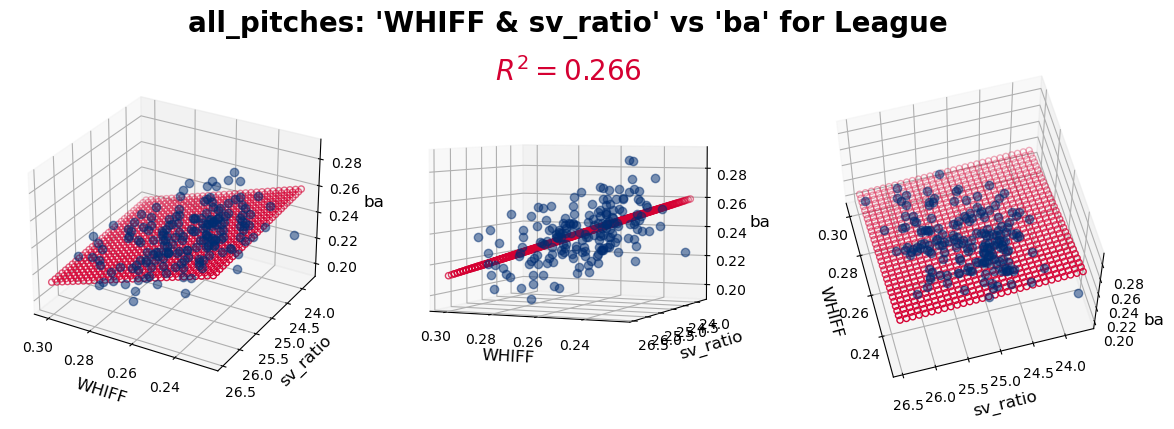

In [26]:
### TEST BOX
x1=['WHIFF']
x2=['WHIFF', 'sv_ratio']
x_plus=['spin_rate','velocity','sv_ratio']

y='ba'

reg_title_all= 'all_pitches'
reg_title_slider= 'slider'
reg_title_4seam= '4-seam fastball'
reg_team = 'NYM'
# SD, TB, NYM

## SIMPLE LEAGUE
# lin_regression(df_league_all, y, x1, 'League',reg_title_all)
# lin_regression(df_league_slider, y, x1, 'League', reg_title_slider)
# lin_regression(df_league_4seam, y, x1, 'League', reg_title_4seam)
## SIMPLE TEAM
# lin_regression(df_team_all, y, x1, reg_team, reg_title_all)
# lin_regression(df_team_slider, y, x1, reg_team, reg_title_slider)
# lin_regression(df_team_4seam, y, x1, reg_team, reg_title_4seam)

## 3D LEAGUE
lin_regression(df_league_all, y, x2,'League',reg_title_all)
# lin_regression(df_league_slider, y, x2, 'League', reg_title_slider)
# lin_regression(df_league_4seam, y, x2, 'League', reg_title_4seam)
## 3D TEAM
# lin_regression(df_team_all, y, x2, reg_team, reg_title_all)
# lin_regression(df_team_slider, y, x2, reg_team, reg_title_slider)
# lin_regression(df_team_4seam, y, x2, reg_team, reg_title_4seam)

## PAIRWISE LEAGUE
# lin_regression(df_league_all, y, x_plus,'League',reg_title_all)
# lin_regression(df_league_slider, y, x_plus, 'League', reg_title_slider)
# lin_regression(df_league_4seam, y, x_plus, 'League', reg_title_4seam)
## PAIRWISE TEAM
# lin_regression(df_team_all, y, x_plus, reg_team, reg_title_all)
# lin_regression(df_team_slider, y, x_plus, reg_team, reg_title_slider)
# lin_regression(df_team_4seam, y, x_plus, reg_team, reg_title_4seam)